# Customer Revenue Prediction

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.
This notebook will analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset from Kaggle competition ['Google Analytics Customer Revenue Prediction'](https://www.kaggle.com/c/ga-customer-revenue-prediction) to predict revenue per customer. 

### About the dataset:

Each row in the dataset is one visit to the store. Targeted outputs are prediction of the natural log of the sum of all transactions per user.

The data fields in the given files are

* fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

Note: some of the fields are in json format, the dataset size is very large. The train and test datasets used in this analysis is a cvs file with json flattened from Kaggle [json flattened csv data](https://www.kaggle.com/colinpearse/ga-analytics-with-json-columns)(thanks to Collin!).

In [1]:
import os
import gc   # garbage collector
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Standard plotly imports
import plotly
import plotly.plotly as py
#plotly.tools.set_credentials_file(username='', api_key='')
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

from PIL import Image
import IPython.display

import warnings
warnings.filterwarnings("ignore")

## Data Visualiztion to Identify Key Features

In [2]:
train = pd.read_csv('./Output/train_p.csv')
train.drop(['Unnamed: 0'],axis=1, inplace=True)
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,geoNetwork.continent,geoNetwork.country,geoNetwork.networkDomain,geoNetwork.subContinent,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,Asia,Turkey,ttnet.com.tr,Western Asia,1,1.0,1.0,0.0,organic,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,Oceania,Australia,dodo.net.au,Australasia,1,1.0,1.0,0.0,organic,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,Europe,Spain,unknown.unknown,Southern Europe,1,1.0,1.0,0.0,organic,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,Asia,Indonesia,unknown.unknown,Southeast Asia,1,1.0,1.0,0.0,organic,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,Europe,United Kingdom,unknown.unknown,Northern Europe,1,NaN,1.0,0.0,organic,google


In [3]:
test = pd.read_csv('./Output/test_p.csv')
test.drop(['Unnamed: 0'],axis=1, inplace=True)

### Target dependent variable exploration

In [4]:
user_rvn = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index(name='Total_Revenue')
user_rvn['Total_Revenue'] = user_rvn['Total_Revenue'].apply(lambda x: np.log(x) if x>0 else 0)
user_nozero_rvn = user_rvn[user_rvn['Total_Revenue']>0]
x = len(user_nozero_rvn)/len(user_rvn)*100
print('Number of unique users: {} \nNumber of customers that contribute to revenue: {}, ~ {}%'.format(len(user_rvn),len(user_nozero_rvn),round(x,2) ))

Number of unique users: 731571 
Number of customers that contribute to revenue: 10223, ~ 1.4%


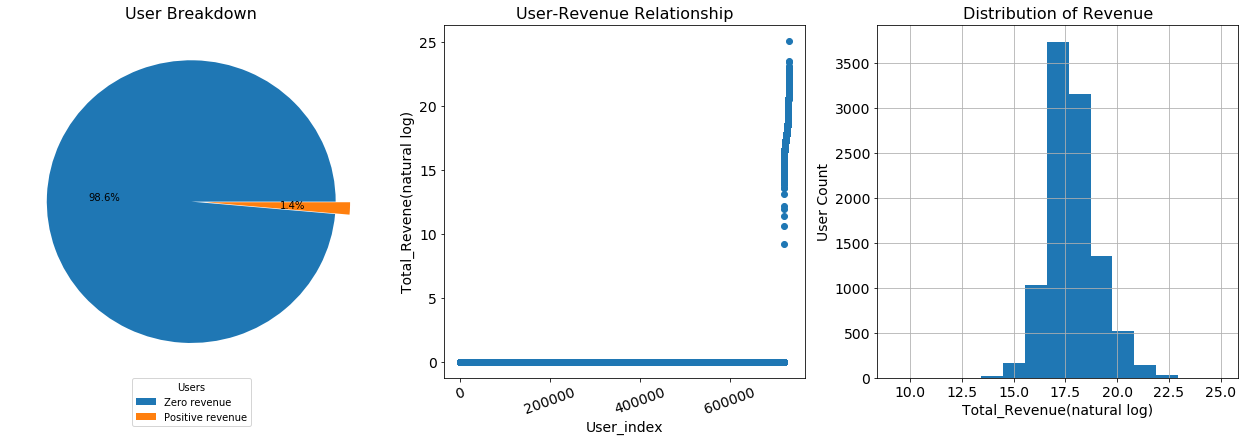

In [5]:
plt.figure(figsize=(22,6.5))

plt.subplot(1,3,1)
plt.pie([98.6,1.4],explode = (0, 0.1), autopct='%1.1f%%')
plt.title('User Breakdown', fontsize=16)
plt.legend(title="Users",labels=['Zero revenue','Positive revenue'],loc="lower center",bbox_to_anchor=(0.5, -0.15))
plt.rcParams['font.size'] = 14

plt.subplot(1,3,2)
plt.scatter(range(user_rvn.shape[0]),np.sort(user_rvn['Total_Revenue'].values))
plt.xlabel('User_index')
plt.ylabel('Total_Revene(natural log)')
plt.title('User-Revenue Relationship',fontsize=16)
plt.xticks(rotation = 20)
# plt.xlim([0,800000])
# plt.ylim([0,25])

plt.subplot(1,3,3)
user_nozero_rvn['Total_Revenue'].hist(bins=15)
plt.title('Distribution of Revenue',fontsize=16)
plt.xlabel('Total_Revenue(natural log)')
plt.ylabel('User Count')

plt.savefig('./Output/1_User-Revenue Overview.png')
plt.show()

### Feature Exploration 1 - Date

In [6]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transaction_count = train.groupby('date')['totals.transactionRevenue'].size().reset_index(name='Total Count')

train_nozero_rvn = train[train['totals.transactionRevenue']>0]
rev_transact_count = train_nozero_rvn.groupby('date')['totals.transactionRevenue'].size().reset_index(name='Total Non-zero Revenue Count')

date_trsact = transaction_count.merge(rev_transact_count, how='outer',on='date')
date_trsact.fillna(value=0,inplace=True)
date_trsact['Total Non-zero Revenue Count'] = date_trsact['Total Non-zero Revenue Count'].apply(lambda x: int(x))
date_trsact['Revenue Rate(%)'] = round(date_trsact['Total Non-zero Revenue Count']/date_trsact['Total Count']*100,2)
date_trsact.head()

,date,Total Count,Total Non-zero Revenue Count,Revenue Rate(%)
0,2016-08-01,1711,34,1.99
1,2016-08-02,2140,17,0.79
2,2016-08-03,2890,0,0.00
3,2016-08-04,3161,17,0.54
4,2016-08-05,2702,41,1.52


In [7]:
#Time Series With Rangeslider

trace_total = go.Scatter(x=date_trsact.date,y=date_trsact['Total Count'],
                         name = "Total Count of User Activity",
                         line = dict(color = '#17BECF'),opacity = 0.8)

trace_rev = go.Scatter(x=date_trsact.date,y=date_trsact['Total Non-zero Revenue Count'],
                       name = "Total Non-zero Revenue Count",
                       line = dict(color = '#7F7F7F'),opacity = 0.8)

data = [trace_total,trace_rev]

layout = dict(
    title='Count of User Activity and Revenue Contributing Activity \n(Time Series with Rangeslider)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~HuiyuanW/0 or inside your plot.ly account where it is named 'Time Series with Rangeslider'


In [8]:
trace_percent = go.Scatter(x=date_trsact.date,y=date_trsact['Revenue Rate(%)'],
                       name = "Percentage of Activity with Revenue Outcome",
                       line = dict(color = '#5E0DAC'),opacity = 0.8)

fig = plotly.tools.make_subplots(rows=3, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Total Activity Count", 
                                          "Date - Non-zero Revenue Activity count", 
                                          "Date - Percentage of Non-zero Revenue Activity"])
fig.append_trace(trace_total, 1, 1)
fig.append_trace(trace_rev, 2, 1)
fig.append_trace(trace_percent, 3, 1)

fig['layout'].update(height=1200, width=800, paper_bgcolor='rgb(233,233,233)', title="Transaction Activity by Date Plots", showlegend=False)
py.iplot(fig, filename='transaction acitivity by date summary plot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



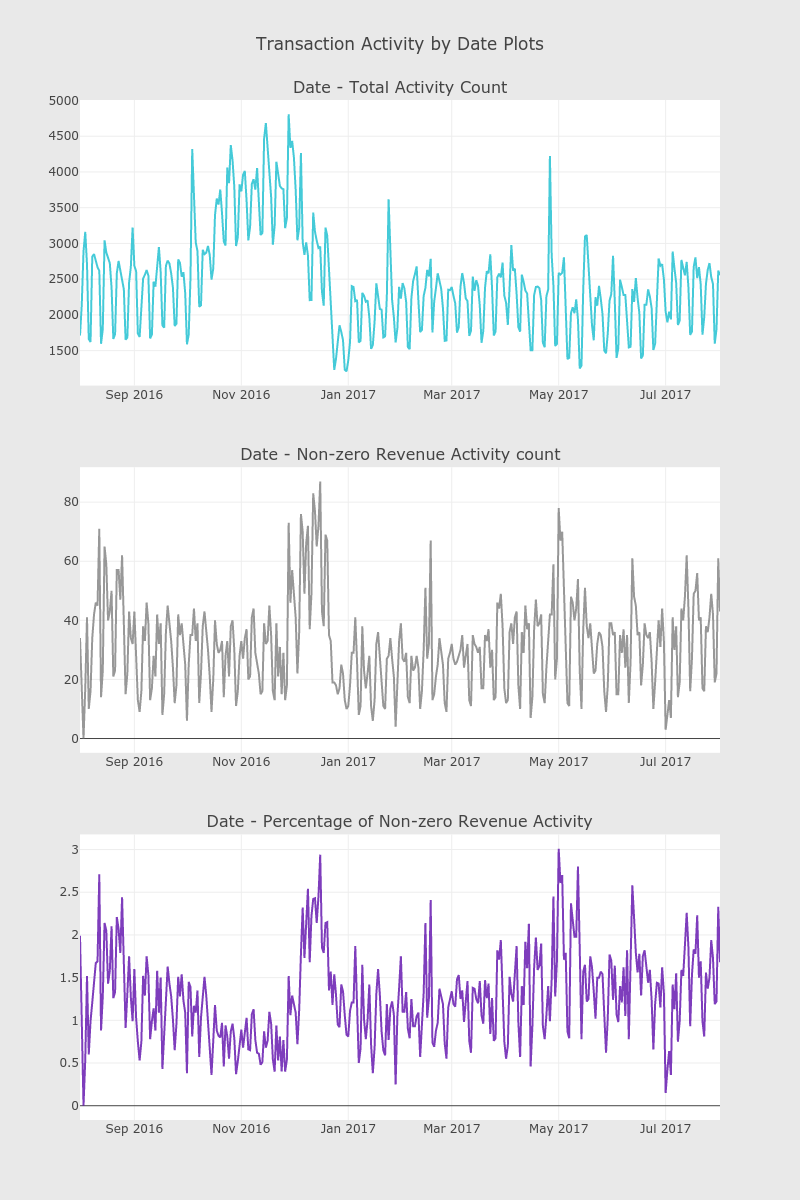

In [9]:
IPython.display.Image('./Output/6_transaction activity by date summary.png', width=1200, height=900)

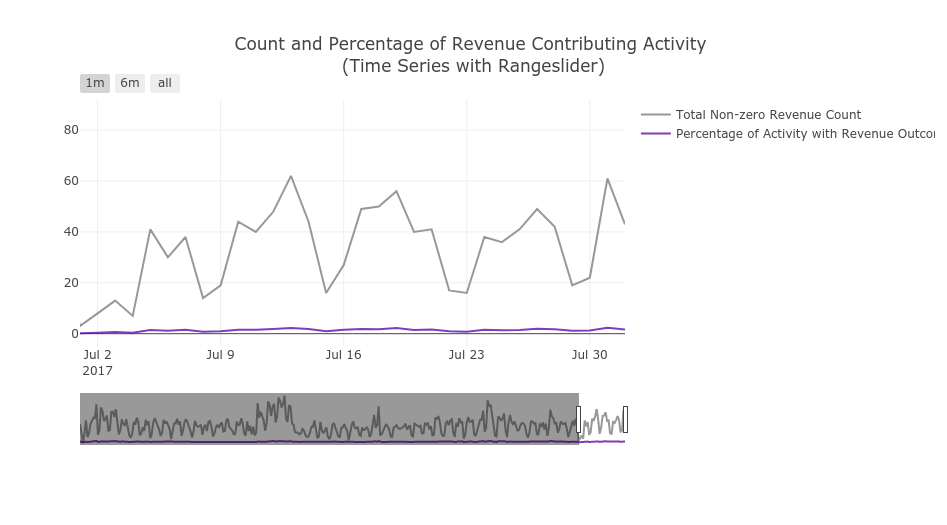

In [10]:
IPython.display.Image('./Output/4_count of revenue activity_1month.png', width=1200, height=900)

#### Time Series User Activity Key Findings
* Both user activity and positive transactions have periodic patten: more activites during some days during a week (inferred from 1-month data pattern). This will be further explored later
* Peak period of mid- to late-Aug 2016 in positive transactions, while no signicant increase in total count activity was observed (can correlate to unavialble data in July 2016)
* Nov 2016, high user activity but low positive transactions; early Dec, positive transactions start to go up even though total count of user activity decrease (customer expection during thanksgiving, late promotion?)
* ~ Valentine's day 2017, high percentage of positive transactions; but total count of user activity on the low range, there is a spike on 1/24
* April 26,2017 spike in total user acvitivity may be related to the follow-up increase of positive transactions

### Feature Exploration 2 - User visit day

In [11]:
# correlate the features and traget variable - transactionRevenue
def cor_feature_Revenue(column_name):
    df01 = train.groupby(column_name)['totals.transactionRevenue'].size().reset_index(name='Count')
    df1 = train_nozero_rvn.groupby(column_name)['totals.transactionRevenue'].agg(['size', 'mean','sum']).reset_index()
    df1.columns=[column_name,'Non-zero Revenue count','Mean Revenue(log scale)','Total Revenue(log scale)']
    df1['Mean Revenue(log scale)']=df1['Mean Revenue(log scale)'].apply(lambda x: round(np.log(x),1))
    df1['Total Revenue(log scale)']=df1['Total Revenue(log scale)'].apply(lambda x: round(np.log(x),1))
    df_tot = df01.merge(df1,on=column_name)
    df_tot['Count%'] = (df_tot['Count']/df_tot['Count'].sum()*100).apply(lambda x: round(x,2))
    df_tot['Non-zero Revenue count%'] = (df_tot['Non-zero Revenue count']/df_tot['Non-zero Revenue count'].sum()*100).apply(lambda x: round(x,2))
    df_tot = df_tot[[column_name,'Count','Count%','Non-zero Revenue count','Non-zero Revenue count%','Mean Revenue(log scale)','Total Revenue(log scale)']]
    df_tot = df_tot.sort_values("Non-zero Revenue count%", ascending=False)
    return df_tot

def plot_feature_Rev(df,column_name,plot_num):
    plt.figure()

    color = 'tab:blue'
    ax1 = df.plot.bar(x=column_name ,y=['Non-zero Revenue count%','Count%'], 
                              color=[color,'lightsteelblue'],figsize=(13,6),rot=0, fontsize=14, grid=False)
    ax1.set_ylabel('Percentage(%)', color=color,fontsize=14)  
    ax1.tick_params(axis='y',labelcolor=color)

    ax2 = ax1.twinx()# instantiate a second axes that shares the same x-axis
    
    color = 'tab:red'
    ax2.set_ylabel('Revenue(log scale)', color=color,fontsize=14)
    ax2.plot(range(len(df)), df['Total Revenue(log scale)'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax3 = ax2.twiny()
    ax3.plot(range(len(df)), df['Mean Revenue(log scale)'], color='lightpink')
    ax3.axis('off')

    plt.grid(b=None)
    
    ax1.legend(loc = (.65,.85), frameon = False)
    ax2.legend( loc = (.65, .8), frameon = False)
    ax3.legend( loc = (.65, .75), frameon = False)

    plt.title(column_name + ' Breakdown & Revenue Info', fontsize = 18)
    
    plt.savefig(os.path.join('./Output', str(plot_num) + '-' + column_name + ' Breakdown & Revenue.png'))
    plt.show()

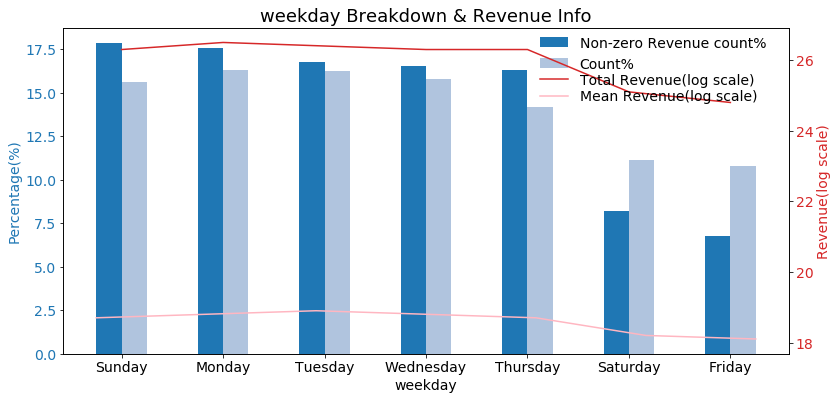

In [12]:
plot_num=7
train['weekday']=train['date'].apply(lambda x: x.weekday())
wkday = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
train=train.replace({'weekday':wkday})
train_nozero_rvn['weekday']=train_nozero_rvn['date'].apply(lambda x: x.weekday())
train_nozero_rvn=train_nozero_rvn.replace({'weekday':wkday})
df_day = cor_feature_Revenue('weekday')
plot_feature_Rev(df_day,'weekday',plot_num)
plot_num += 1

#### User Visit Day Key Findings
* Sunday has the highest amount of transaction completion, while Friday has the lowest number of transaction
* Customers prefer to browse and place orders during the period of Sunday through Thursday

### Feature Exploration 3 - User visit starttime

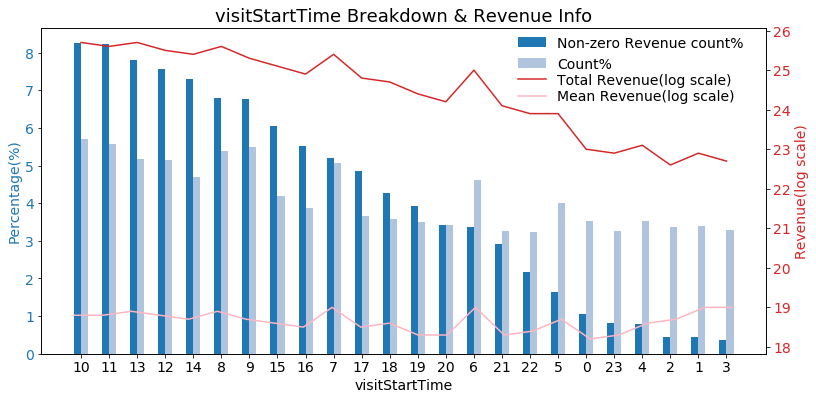

In [13]:
# convert starttime to hour at a 24hr scale
train['visitStartTime'] = train['visitStartTime']. apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%-H'))
train_nozero_rvn['visitStartTime'] = train_nozero_rvn['visitStartTime']. apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%-H'))
df_st = cor_feature_Revenue('visitStartTime')
plot_feature_Rev(df_st,'visitStartTime',plot_num)
plot_num += 1

#### User Visit Starttime Key Findings
* Information of city is not available for accurate analysis, but since over 90% of customers are located in US, the trend from current analysis can be valid.
* Customers like placing orders during the daytime, the highest numbers of transactions are completed between 10am-2pm, with peak at 10am-noon.

### Feature Exploration 4 - Source Channel

In [14]:
ChnGrp_tot = cor_feature_Revenue('channelGrouping')
ChnGrp_tot

,channelGrouping,Count,Count%,Non-zero Revenue count,Non-zero Revenue count%,Mean Revenue(log scale),Total Revenue(log scale)
6,Referral,104838,11.60,5311,46.12,18.6,27.2
4,Organic Search,381561,42.22,3438,29.86,18.4,26.5
2,Direct,143026,15.83,2042,17.73,19.2,26.8
5,Paid Search,25326,2.80,468,4.06,18.3,24.5
3,Display,6262,0.69,142,1.23,20.1,25.1
7,Social,226117,25.02,104,0.90,17.7,22.3
1,Affiliates,16403,1.82,9,0.08,18.0,20.2
0,(Other),120,0.01,1,0.01,16.1,16.1


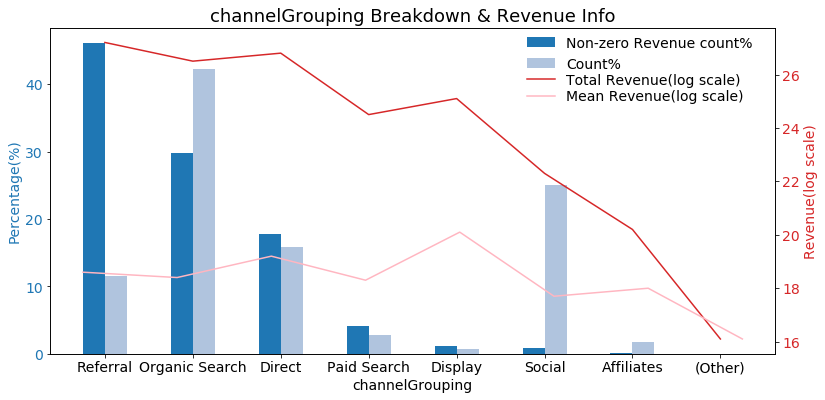

In [15]:
plot_feature_Rev(ChnGrp_tot,'channelGrouping',plot_num)
plot_num += 1

#### channelGrouping Breakdown Key Findings
* Referral resulted in the most of positive revnue transaction counts and highest total revenue, followed by Organic Seach and Direct
* Organic Search and Social consitute over 60% of total user activity count
* Display has the highest mean revenue, followed by Direct

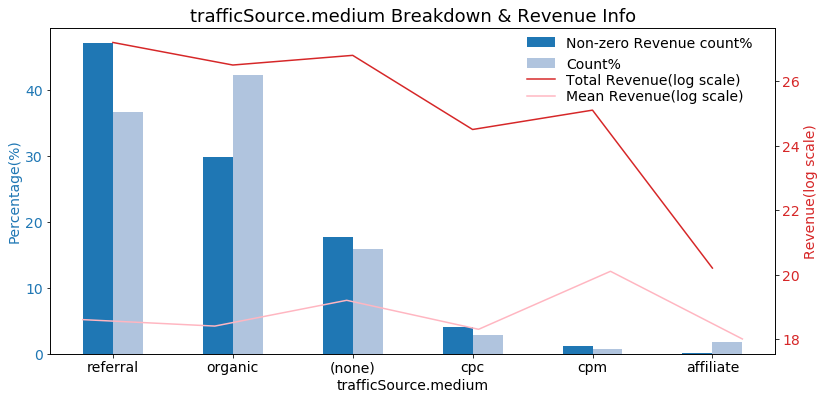

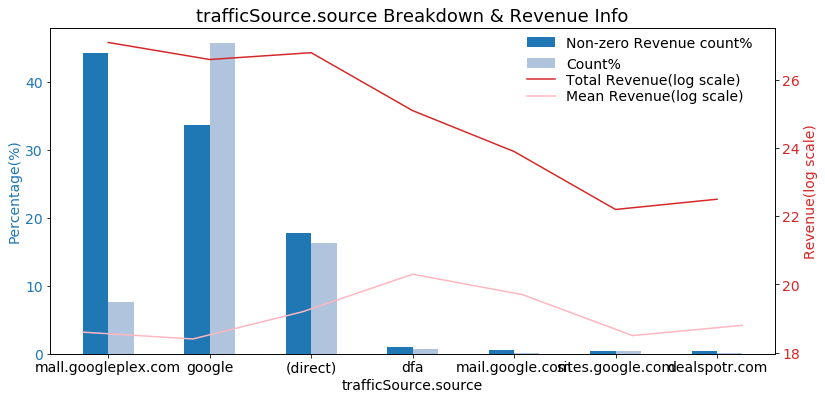

In [16]:
for column_name in ['trafficSource.medium','trafficSource.source']:
    df = cor_feature_Revenue(column_name).head(7)
    plot_feature_Rev(df,column_name,plot_num)
    plot_num += 1

#### trafficSource Breakdown Key Findings
* Medium showed similar trend with channelGrouping, with referral and organic search contributing to the most positive transaction counts and revenue;
      - Additionally, cpm showed the highest mean revenue
* Source showed that most customers come from google source, and dfa had the highest mean revenue

### Feature Exploration 5 - Device and Platform

In [17]:
print(train.columns)

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.medium', 'trafficSource.source', 'weekday'],
      dtype='object')


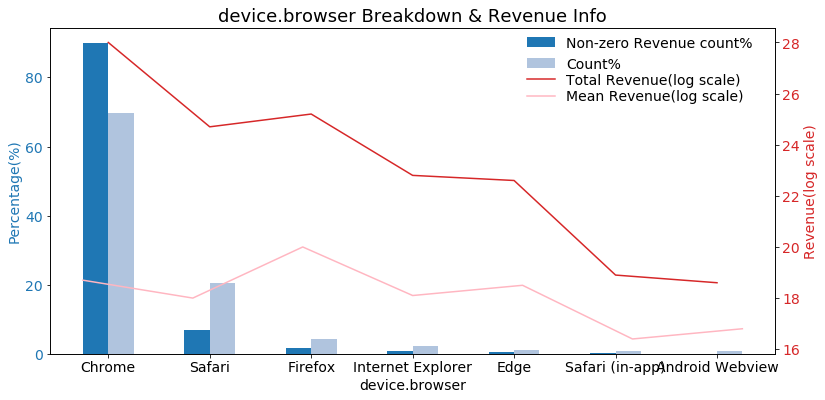

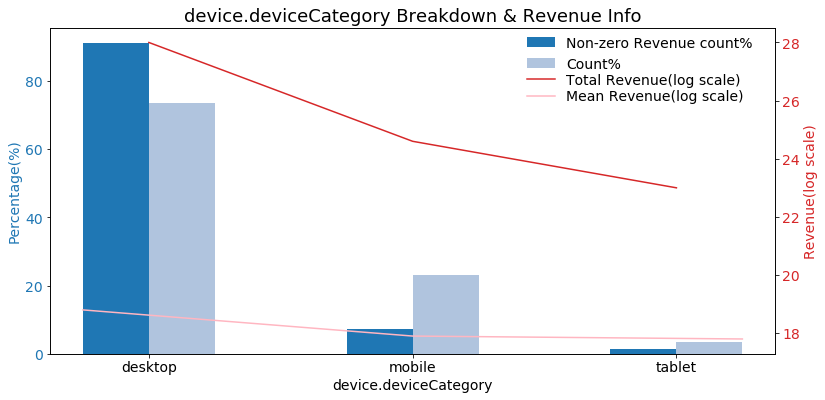

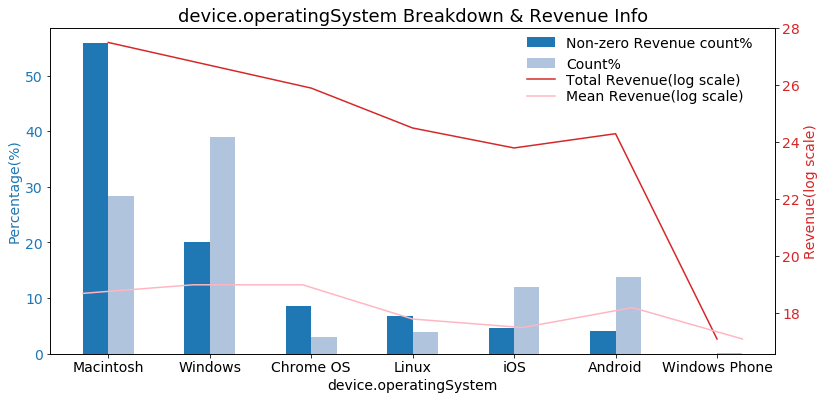

In [18]:
for column_name in ['device.browser','device.deviceCategory', 'device.operatingSystem']:
    df = cor_feature_Revenue(column_name).head(7)
    plot_feature_Rev(df,column_name,plot_num)
    plot_num += 1

#### Device & Platform breakdown key findings
* Web browser: Chrome has the highest transactions and total revenues; interestingly, firefox users contributed to the highest mean revenue
* Over 70% users used computers to browse products; over 90% customers used computers to place orders
* Macintosh and Windows users are the two groups contributing to the highest transactions and total revenue
* Chrome OS and ANdroid users have relatively high mean revenue within the desktop and mobile user groups, respectively

### Feature Exploration 6 - User Geography 

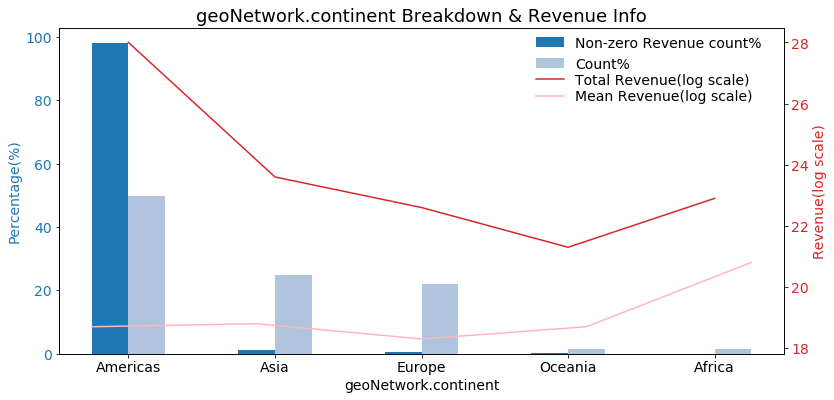

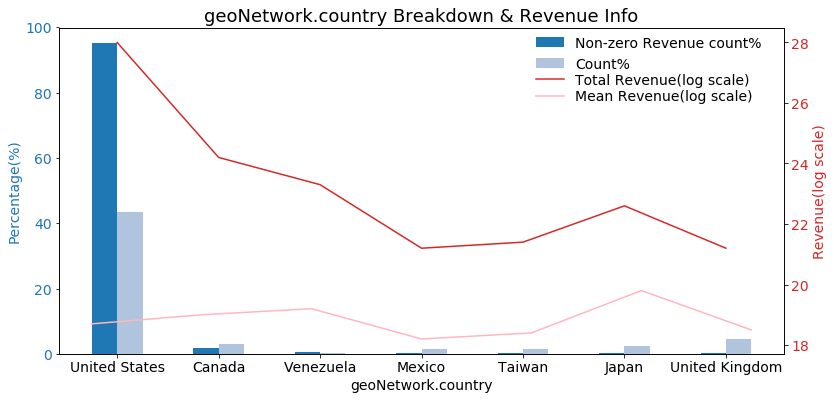

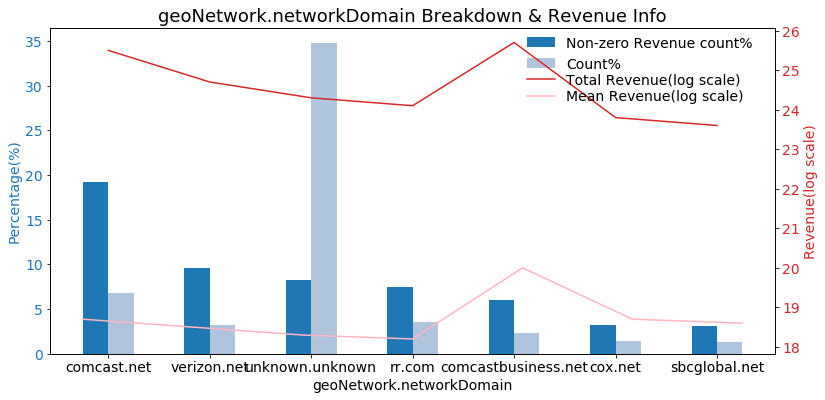

In [19]:
for column_name in ['geoNetwork.continent', 'geoNetwork.country','geoNetwork.networkDomain']:
    df = cor_feature_Revenue(column_name).head(7)
    plot_feature_Rev(df,column_name,plot_num)
    plot_num += 1

In [20]:
Geo_tot = cor_feature_Revenue('geoNetwork.country')

data = [go.Choropleth(
    locations = Geo_tot['geoNetwork.country'],
    z = Geo_tot['Total Revenue(log scale)'],
    text = Geo_tot['geoNetwork.country'],
    locationmode = 'country names',
    autocolorscale = False,
    marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
    colorbar = dict(
        tickprefix = '',
        title = 'Total Revenue (log scale)'),
      ) ]
    
layout = dict(
    title = 'Total Revenue by Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
) 

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'Total Revenue by Country')

In [21]:
# plot count%, non-zero revenue count%, and mean revenue geo maps
Geo_tot = cor_feature_Revenue('geoNetwork.country')

def plot_geomap(target):
    data = [go.Choropleth(
    locations = Geo_tot['geoNetwork.country'],
    z = Geo_tot[target],
    text = Geo_tot['geoNetwork.country'],
    locationmode = 'country names',
    autocolorscale = False,
    marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
    colorbar = dict(
        tickprefix = '',
        title = target),
      ) ]
    
    layout = dict(
        title = target + ' by Country',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'equirectangular'
            )
        )
    ) 

    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig, filename = target + ' by Country')
    
for column in ['Count%','Non-zero Revenue count%','Total Revenue(log scale)','Mean Revenue(log scale)']:
    plot_geomap(column)
    plot_num += 1

In [22]:
# combine 4 geo plots into one image
files = ['./Output/17-Count% by Country.png', './Output/18-Nonzero Revenue count% by Country.png',
         './Output/16-Total Revenue by Country.png','./Output/19-Mean Revenue by Country.png']

result = Image.new("RGB", (1360, 960))

for index, file in enumerate(files):
  img = Image.open(file)
  img.thumbnail((680, 540), Image.ANTIALIAS)
  x = index // 2 * 680
  y = index % 2 * 480
  w, h = img.size
  #print('pos {0},{1} size {2},{3}'.format(x, y, w, h))
  result.paste(img, (x, y, x + w, y + h))

result.save('./Output/20-GeoSummary.png')
plot_num += 1

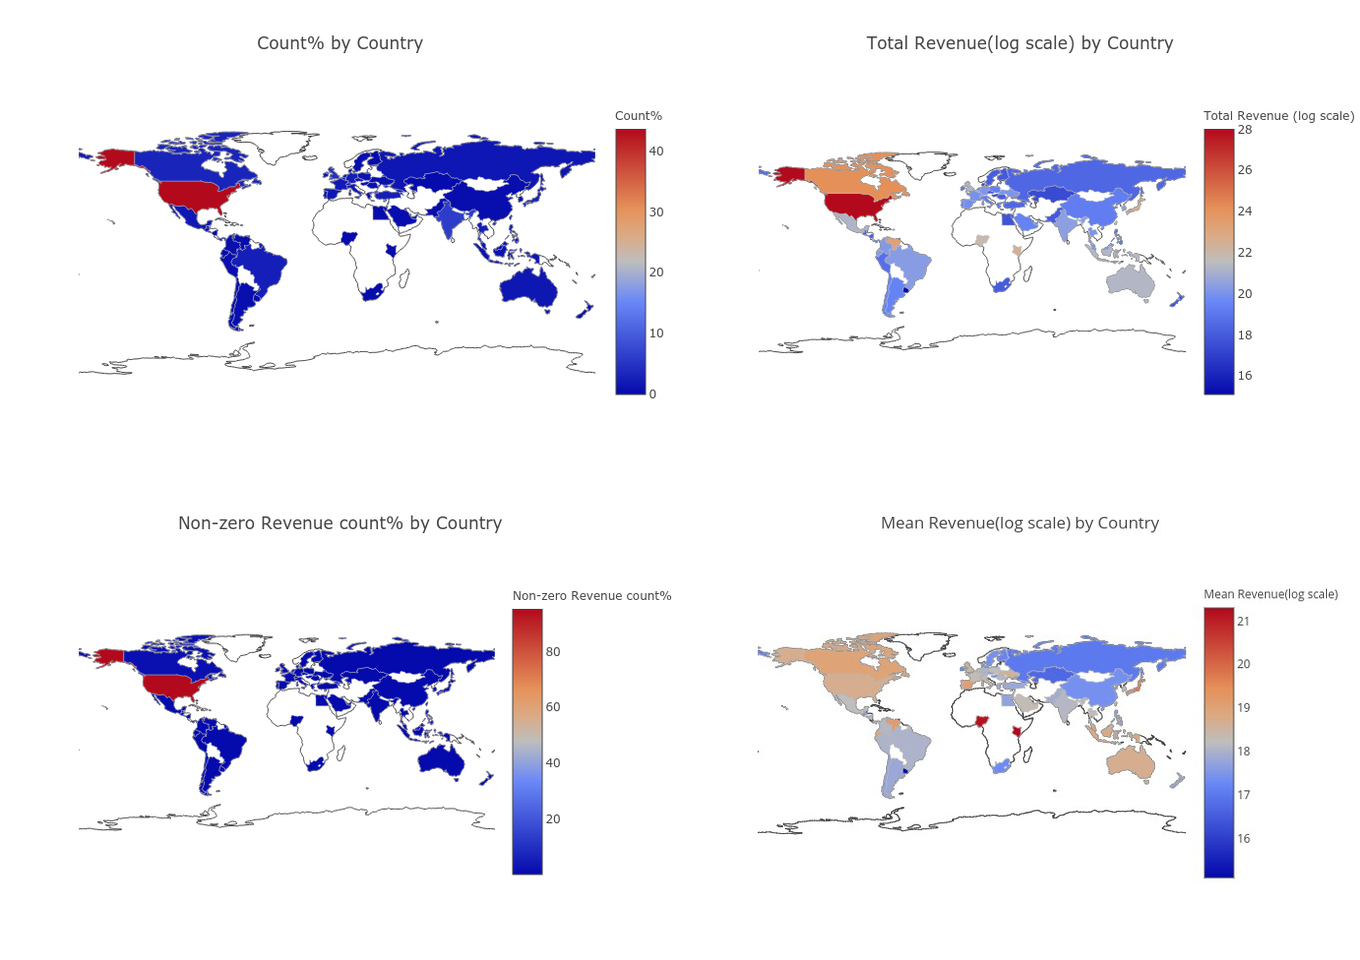

In [23]:
IPython.display.Image('./Output/20-GeoSummary.png', width=1200, height=900)

#### geoNetwork Breakdown Key Findings
* North America, mostly United States, contributes to the revenue the most, followed by Canada and Venezuela
* Africa has relatively high revenue, even though not as many visit counts as other continents; Nigeria and Kenya have the highest mean revenue
* Comcastbusiness.net and comcast.net users contributed to the most revenue among the network domains; correlates to previous findings that most customers use computers to browse products and place orders
* Verizon is on the top5 revenue sources, but not AT&T and T-mobile

### Feature Exploration 7 - User page visit

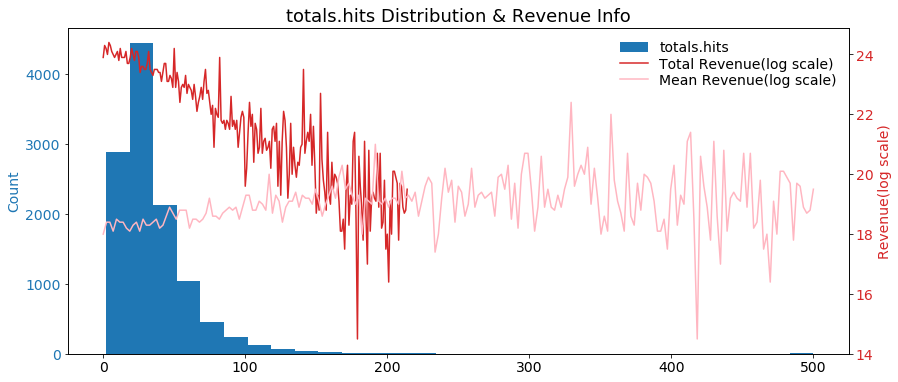

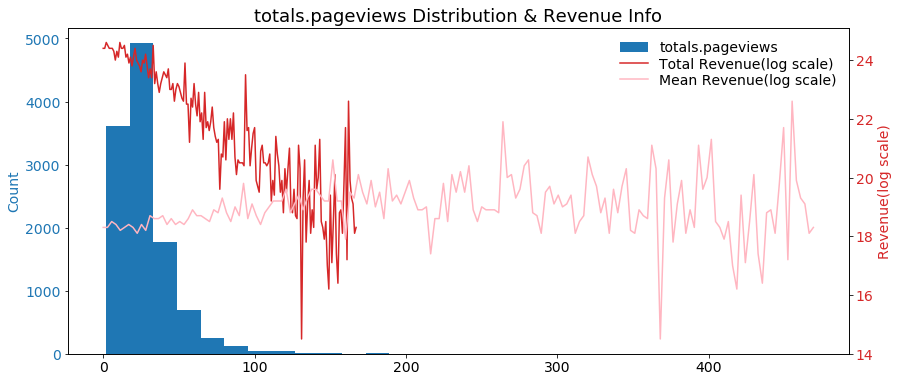

In [24]:
def plothist_feature_Rev(df,column_name,plot_num):

    fig = plt.figure()
     
    color = 'tab:blue'
    ax1 = train_nozero_rvn[[column_name]].plot.hist(color=color, bins=30,figsize=(14,6),grid=False)
    ax1.set_ylabel('Count', color=color,fontsize=14)  
    ax1.tick_params(axis='y',labelcolor=color)
    plt.legend(loc = (.7, .9), frameon = False)

    ax2 = ax1.twinx()# instantiate a second axes that shares the same x-axis
    
    color = 'tab:red'
    ax2.set_ylabel('Revenue(log scale)', color=color,fontsize=14)
    ax2.plot(range(len(df)), df['Total Revenue(log scale)'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax3 = ax2.twiny()
    ax3.plot(range(len(df)), df['Mean Revenue(log scale)'], color='lightpink')
    ax3.axis('off')

    plt.grid(b=None)
    
    ax2.legend(loc = (.7, .85), frameon = False)
    ax3.legend(loc = (.7, .8), frameon = False)
    
    plt.title(column_name + ' Distribution & Revenue Info', fontsize = 18)
    
    plt.savefig(os.path.join('./Output', str(plot_num) + '-' + column_name + ' Distribution & Revenue.png'))
    plt.show()

for column_name in ['totals.hits', 'totals.pageviews']:
    df = cor_feature_Revenue(column_name)
    plothist_feature_Rev(df,column_name,plot_num) 
    plot_num += 1

#### User Page Visit Key Findings
* Most users have less than 100 hits and pageviews
* Users with less than 40 hits and pageviews contribute to the most revenues